In [1]:
import sys
from pathlib import Path
from copy import deepcopy
import torch

try:
    if not(changed):
        raise Exception()
except:
    sys.path.append(str(Path(".").absolute().parent))
    changed = True

In [2]:
from ocpmodels.common.flags import flags
from ocpmodels.common.utils import build_config, resolve, setup_imports, merge_dicts
from ocpmodels.trainers.single_trainer import SingleTrainer

In [27]:
runs_dir = "$SCRATCH/ocp/runs"
job_id = "3918728"

path = resolve(runs_dir) / job_id

checkpoint = path / "checkpoints" / "best_checkpoint.pt"
setup_imports()
argv = deepcopy(sys.argv)
# trainer_args = flags.parser.parse_args()
trainer_args = flags.parser.parse_args([])
sys.argv[1:] = argv
trainer_args.continue_from_dir = str(path)
config = build_config(trainer_args, [])
config["logger"] = "dummy"
config["checkpoint"] = str(checkpoint)
print(config)

ewald_trainer = SingleTrainer(**config)

🅾️  Removing orion config from continue config. Set to None: {}
✅ Loading config from /network/scratch/a/ali.ramlaoui/ocp/runs/3918728/checkpoints/checkpoint-0021588.pt (and loading latest checkpoint)
🏭 Overriding num_workers from 4 to 1 to match the machine's CPUs. Use --no_cpus_to_workers=true to disable this behavior.
{'frame_averaging': '', 'fa_method': '', 'model': {'name': 'faenet', 'act': 'swish', 'hidden_channels': 384, 'num_filters': 480, 'num_interactions': 5, 'num_gaussians': 104, 'dropout_lin': 0.0, 'dropout_edge': 0.0, 'dropout_lowest_layer': 'output', 'first_trainable_layer': '', 'cutoff': 6.0, 'use_pbc': True, 'regress_forces': '', 'tag_hidden_channels': 64, 'pg_hidden_channels': 64, 'phys_embeds': True, 'phys_hidden_channels': 0, 'energy_head': 'weighted-av-final-embeds', 'skip_co': 'concat', 'second_layer_MLP': False, 'complex_mp': True, 'mp_type': 'base', 'graph_norm': True, 'force_decoder_type': 'mlp', 'force_decoder_model_config': {'simple': {'hidden_channels': 128,

In [26]:
runs_dir = "$SCRATCH/ocp/runs"
job_id = "3917846"

path = resolve(runs_dir) / job_id

checkpoint = path / "checkpoints" / "best_checkpoint.pt"
setup_imports()
argv = deepcopy(sys.argv)
# trainer_args = flags.parser.parse_args()
trainer_args = flags.parser.parse_args([])
sys.argv[1:] = argv
trainer_args.continue_from_dir = str(path)
config = build_config(trainer_args, [])
config["logger"] = "dummy"
config["checkpoint"] = str(checkpoint)
print(config)

base_trainer = SingleTrainer(**config)

🅾️  Removing orion config from continue config. Set to None: {}
✅ Loading config from /network/scratch/a/ali.ramlaoui/ocp/runs/3917846/checkpoints/checkpoint-0021588.pt (and loading latest checkpoint)
🏭 Overriding num_workers from 4 to 1 to match the machine's CPUs. Use --no_cpus_to_workers=true to disable this behavior.
{'frame_averaging': '', 'fa_method': '', 'model': {'name': 'faenet', 'act': 'swish', 'hidden_channels': 384, 'num_filters': 480, 'num_interactions': 5, 'num_gaussians': 104, 'dropout_lin': 0.0, 'dropout_edge': 0.0, 'dropout_lowest_layer': 'output', 'first_trainable_layer': '', 'cutoff': 6.0, 'use_pbc': True, 'regress_forces': '', 'tag_hidden_channels': 64, 'pg_hidden_channels': 64, 'phys_embeds': True, 'phys_hidden_channels': 0, 'energy_head': 'weighted-av-final-embeds', 'skip_co': 'concat', 'second_layer_MLP': False, 'complex_mp': True, 'mp_type': 'base', 'graph_norm': True, 'force_decoder_type': 'mlp', 'force_decoder_model_config': {'simple': {'hidden_channels': 128,

In [32]:
dataset = trainer.datasets["train"]

def get_activation(name, activation):
    def hook(model, input, output):
        activation[name] = output
    return hook

In [33]:
loader = base_trainer.get_dataloader(trainer.datasets["train"], trainer.samplers["train"])

ewald_activation = {}
base_activation = {}

for i, block in enumerate(ewald_trainer.model.module.interaction_blocks):
    block.register_forward_hook(get_activation(f"{block.__class__.__name__}_{i}", ewald_activation))
for i, block in enumerate(ewald_trainer.model.module.ewald_blocks):
    block.register_forward_hook(get_activation(f"{block.__class__.__name__}_{i}", ewald_activation))

for i, block in enumerate(base_trainer.model.module.interaction_blocks):
    block.register_forward_hook(get_activation(f"{block.__class__.__name__}_{i}", base_activation))

with torch.no_grad():
    ewald_output = ewald_trainer.model_forward(next(iter(loader)))
    base_output = base_trainer.model_forward(next(iter(loader)))

In [16]:
activation["EwaldBlock_0"][0].shape

torch.Size([6519, 384])

In [22]:
activation["InteractionBlock_0"].shape

torch.Size([6519, 384])

torch.Size([6519, 384])
torch.Size([6519, 384])
torch.Size([6519, 384])
torch.Size([6519, 384])
torch.Size([6519, 384])


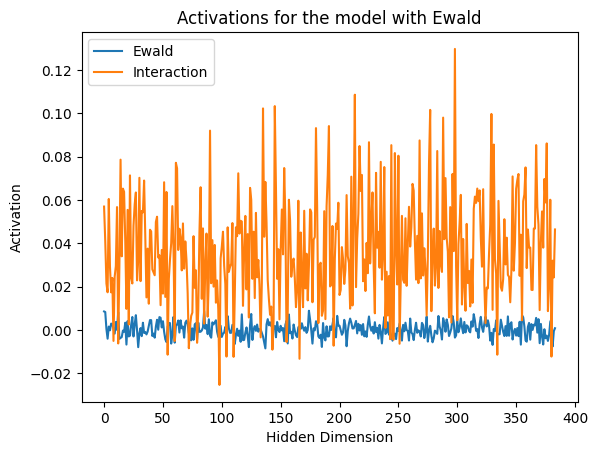

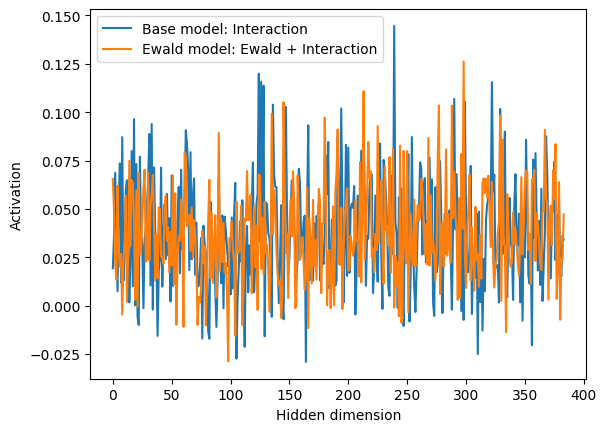

In [68]:
# Plot activations
import matplotlib.pyplot as plt
import numpy as np

ewald_values = []
for key, value in ewald_activation.items():
    if "EwaldBlock" in key:
        print(value[0].shape)
        value = value[0].cpu().numpy().mean(axis=0)
        ewald_values.append(value.reshape(1, -1))
ewald_values = np.concatenate(ewald_values, axis=0)
plt.plot(ewald_values.mean(0), label="Ewald")

interaction_values = []
for key, value in ewald_activation.items():
    if "InteractionBlock" in key:
        value = value.cpu().numpy().mean(axis=0)
        interaction_values.append(value.reshape(1, -1))
interaction_values = np.concatenate(interaction_values, axis=0)
plt.plot(interaction_values.mean(0), label="Interaction")
plt.legend()
plt.xlabel("Hidden dimension")
plt.ylabel("Activation")
plt.title("Activations for the model with Ewald")
plt.show()


base_interaction_values = []
for key, value in base_activation.items():
    if "InteractionBlock" in key:
        value = value.cpu().numpy().mean(axis=0)
        base_interaction_values.append(value.reshape(1, -1))
base_interaction_values = np.concatenate(base_interaction_values, axis=0)
plt.plot(base_interaction_values.mean(0), label="Base model: Interaction")
plt.plot(interaction_values.mean(0) + ewald_values.mean(0), label="Ewald model: Ewald + Interaction")
# plt.plot(interaction_values.mean(0), label="Ewald model: Interaction")
plt.xlabel("Hidden dimension")
plt.ylabel("Activation")
plt.legend()
plt.show()